# BAF627 HW1 

20249433 MFE 최재필


In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import scipy.optimize as sco

from tqdm import tqdm

In [12]:
np.random.seed(42)

In [13]:
CWD = Path.cwd()
OUTPUT_PATH = CWD / 'output'

## 0. Import Data

In [14]:
msf = pd.read_csv('msf.csv')
msp500_rf = pd.read_csv('msp500_risk_free.csv')

In [15]:
msf['mdate'] = pd.to_datetime(msf['mdate'])

In [16]:
msp500_rf['mdate'] = pd.to_datetime(msp500_rf['mdate'])

In [17]:
msf_ret = msf[['mdate', 'ticker', 'ret']].pivot(index='mdate', columns='ticker', values='ret')
msf_ret.tail()

ticker,AAPL,ABT,ADBE,ADI,ADP,ADSK,AIG,AMAT,AMD,AMGN,...,TMO,TXN,UNH,UNP,USB,VZ,WFC,WM,WMT,XOM
mdate,,,,,,,,,,,,,,,,,,,,,
2021-08-31,0.042438,0.044553,0.067677,-0.022578,-0.002815,-0.034379,0.152270,-0.032588,0.042659,-0.058996,...,0.027666,0.001521,0.009825,-0.003886,0.033309,-0.013983,-0.000871,0.046203,0.042792,-0.037867
2021-09-30,-0.068037,-0.065205,-0.132560,0.027800,-0.039179,-0.080364,0.011913,-0.047362,-0.070629,-0.057110,...,0.029985,0.006810,-0.057847,-0.096062,0.043736,-0.018000,0.015536,-0.033363,-0.058879,0.078870
2021-10-31,0.058657,0.094895,0.129646,0.035885,0.122899,0.113757,0.076517,0.061524,0.168416,-0.026711,...,0.108064,-0.018626,0.178456,0.231570,0.015646,-0.007036,0.102349,0.072777,0.072033,0.096056
2021-11-30,0.104940,-0.024207,0.029968,0.038965,0.028509,-0.199679,-0.109832,0.078888,0.317225,-0.030584,...,-0.000379,0.026083,-0.035290,-0.023861,-0.083320,-0.051330,-0.062158,0.002746,-0.058827,-0.058167
2021-12-31,0.074229,0.119027,-0.153452,-0.021026,0.072459,0.106220,0.087072,0.069094,-0.091368,0.131185,...,0.054786,-0.020273,0.133650,0.074138,0.023310,0.033618,0.004186,0.042354,0.032781,0.022560


In [18]:
sp500_s = msp500_rf[['mdate', 'spindx']].set_index('mdate')
sp500_ret = sp500_s.pct_change().dropna()

In [19]:
rf_s = msp500_rf[['mdate', 'rf']].set_index('mdate')

In [20]:
sp500_excess_ret = sp500_ret['spindx'] - rf_s['rf']
msf_excess_ret = msf_ret.subtract(rf_s['rf'], axis=0)

## 1. No risk-free asset & Short-selling is allowed

Case #2

In [21]:
cov_df = msf_ret.cov()
mean_s = msf_ret.mean()

In [22]:
std_s = msf_ret.std()

In [23]:
cov_2d = cov_df.values
mean_v = mean_s.values
std_v = std_s.values

In [24]:
sid_list = mean_s.index
sid_list

Index(['AAPL', 'ABT', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AIG', 'AMAT', 'AMD',
       'AMGN', 'APD', 'AXP', 'BA', 'BAC', 'BDX', 'BK', 'BMY', 'BRK', 'C',
       'CAT', 'CDNS', 'CI', 'CL', 'COP', 'COST', 'CSX', 'CVS', 'CVX', 'D',
       'DE', 'DHR', 'DIS', 'DUK', 'ECL', 'EMR', 'EOG', 'EXC', 'F', 'FDX',
       'FISV', 'GD', 'GE', 'HD', 'HON', 'HUM', 'IBM', 'INTC', 'ITW', 'JNJ',
       'JPM', 'KLAC', 'KMB', 'KO', 'LLY', 'LMT', 'LOW', 'LRCX', 'MCD', 'MCO',
       'MMC', 'MMM', 'MNST', 'MO', 'MRK', 'MS', 'MSFT', 'MSI', 'MU', 'NEE',
       'NEM', 'NKE', 'NOC', 'NSC', 'ORCL', 'PAYX', 'PEP', 'PFE', 'PG', 'PGR',
       'PNC', 'RTX', 'SCHW', 'SHW', 'SO', 'SPGI', 'SYK', 'T', 'TFC', 'TGT',
       'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'USB', 'VZ', 'WFC', 'WM', 'WMT',
       'XOM'],
      dtype='object', name='ticker')

In [25]:
date_list = msf_ret.index
date_list

DatetimeIndex(['1990-01-31', '1990-02-28', '1990-03-31', '1990-04-30',
               '1990-05-31', '1990-06-30', '1990-07-31', '1990-08-31',
               '1990-09-30', '1990-10-31',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', name='mdate', length=384, freq=None)

### (a) 

- Derive the mean-variance frontier using the standard deviation for measuring risk
- Plot the mean-variance frontier
- Indicate the global minimum portfolio (GMVP) on the plot

Note: Raw returns are used to plot efficient frontier

In [26]:
def port_mean(W, mean_v, rf=0):
    """Get the mean of the portfolio

    Args:
        W (np.ndarray): 1*n array of weights
        mean_v (np.ndarray): 1*n array of mean returns

    Returns:
        float: weighted mean return of the portfolio. (1, ) scalar
    """
    return np.dot(W, mean_v - rf)

In [27]:
# Test the function

n = len(mean_v)
W = np.ones((1, n)) / n

In [28]:
port_mean(W, mean_v) 

array([0.0146253])

In [29]:
def port_var(W, cov_2d):
    """Get the variance of the portfolio

    Args:
        W (np.ndarray): 1*n array of weights
        cov_2d (np.ndarray): n*n array of covariance matrix

    Returns:
        float: variance of the portfolio. (1, 1) array
    """    
    return np.dot(W, np.dot(cov_2d, W.T))

In [30]:
port_var(W, cov_2d)

array([[0.00194029]])

In [31]:
def negative_port_sharpe(W, mean_v, cov_2d):
    """Get the Sharpe ratio of the portfolio

    Args:
        W (np.ndarray): 1*n array of weights
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix

    Returns:
        float: Sharpe ratio of the portfolio. (1, 1) array
    """    

    mean_p = port_mean(W, mean_v)
    std_p = np.sqrt(port_var(W, cov_2d))

    if mean_p > 0:
        return -1 * mean_p / std_p # negative Sharpe ratio
    else:
        return mean_p / std_p # positive Sharpe ratio

In [32]:
negative_port_sharpe(W, mean_v, cov_2d)

array([[-0.33202557]])

In [33]:
def optimize_portfolio(mean_v, cov_2d):
    """Optimize the portfolio to get the maximum Sharpe ratio

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        rf (float): risk-free rate

    Returns:
        scipy.optimize.OptimizeResult: Result of the optimization
    """
    n = len(mean_v)
    args = (mean_v, cov_2d)
    constraints = {
        "type": "eq",
        "fun": lambda W: np.sum(W) - 1,
    }
    bounds = tuple((-1, 1) for asset in range(n))

    result = sco.minimize(
        negative_port_sharpe,  # Minimize the negative Sharpe ratio = maximize the Sharpe ratio
        n * [1.0 / n,],  # Initial guess
        args=args,  # asset returns, covariance matrix
        method="SLSQP",
        bounds=bounds,  # weights between -1 and 1
        constraints=constraints,  # weights sum to 1
    )

    return result

In [34]:
def optimize_portfolio_given_return(ret, mean_v, cov_2d):
    """Optimize the portfolio to get the maximum Sharpe ratio

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        rf (float): risk-free rate

    Returns:
        scipy.optimize.OptimizeResult: Result of the optimization
    """
    n = len(mean_v)
    args = (mean_v, cov_2d)
    constraints = [
        {"type": "eq", "fun": lambda W: np.sum(W) - 1,}, 
        {"type": "eq", "fun": lambda W: port_mean(W, mean_v) - ret,}
        ]
    bounds = tuple((-1, 1) for asset in range(n))

    result = sco.minimize(
        negative_port_sharpe,  # Minimize the negative Sharpe ratio = maximize the Sharpe ratio
        n * [1.0 / n,],  # Initial guess
        args=args,  # asset returns, covariance matrix
        method="SLSQP",
        bounds=bounds,  # weights between -1 and 1
        constraints=constraints,  # weights sum to 1, return target
    )

    return result

In [35]:
optimize_portfolio(mean_v, cov_2d) # optimized result의 x가 optimal weights

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6829405383153178
       x: [ 3.854e-02  4.338e-02 ...  2.784e-02  1.427e-02]
     nit: 24
     jac: [-1.635e-04 -6.117e-06 ... -7.313e-05 -2.860e-04]
    nfev: 2452
    njev: 24

In [36]:
def get_opportunity_set(mean_v, cov_2d, num_portfolios=100):
    """Get the opportunity set by generating random portfolios

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        num_portfolios (int): number of random portfolios to generate

    Returns:
        np.ndarray: 3 * num_portfolios array of results // (portfolio return, portfolio std, portfolio sharpe ratio)
        list: list of weights
    """

    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.uniform(-1, 1, len(mean_v))
        weights /= np.sum(np.abs(weights))
        # TODO: Weights don't sum to 1. If normalized, the resulting efficient frontier breaks.

        p_ret, p_std = port_mean(weights, mean_v), np.sqrt(port_var(weights, cov_2d))
        results[0, i] = p_ret
        results[1, i] = p_std
        results[2, i] = p_ret / p_std

        weights_record.append(weights)
    
    return results, weights_record
    

In [37]:
def get_efficient_frontier(mean_v, cov_2d, return_range=[-0.1, 0.1], num_portfolios=100):
    """Get the efficient frontier by optimizing the portfolio for each return given the range

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        return_range (list): range of return to optimize the portfolio
        num_portfolios (int): number of portfolios to generate

    Returns:
        np.ndarray: 3 * num_portfolios array of results // (portfolio return, portfolio std, portfolio sharpe ratio)
        list: list of weights
    """
    weights_record = []

    min_ret, max_ret = return_range
    ret_range = np.linspace(min_ret, max_ret, num_portfolios)
    results = np.zeros((3, len(ret_range)))

    for i, ret in enumerate(ret_range):
        result = optimize_portfolio_given_return(ret, mean_v, cov_2d)
        weights = result.x

        p_ret, p_std = port_mean(weights, mean_v), np.sqrt(port_var(weights, cov_2d))
        results[0, i] = p_ret
        results[1, i] = p_std
        results[2, i] = p_ret / p_std

        weights_record.append(weights)
        
    return results, weights_record
    

In [38]:
from concurrent.futures import ThreadPoolExecutor, as_completed


def calculate_optimization(ret, mean_v, cov_2d):
    """Helper function to perform optimization and return results"""
    result = optimize_portfolio_given_return(ret, mean_v, cov_2d)
    weights = result.x
    p_ret = port_mean(weights, mean_v)
    p_std = np.sqrt(port_var(weights, cov_2d))
    sharpe_ratio = p_ret / p_std
    return p_ret, p_std, sharpe_ratio, weights

def get_efficient_frontier_parallel(mean_v, cov_2d, return_range=[-0.1, 0.1], num_portfolios=100):
    """Get the efficient frontier by optimizing the portfolio for each return given the range

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        return_range (list): range of return to optimize the portfolio
        num_portfolios (int): number of portfolios to generate

    Returns:
        np.ndarray: 3 * num_portfolios array of results // (portfolio return, portfolio std, portfolio sharpe ratio)
        list: list of weights
    """
    min_ret, max_ret = return_range
    ret_range = np.linspace(min_ret, max_ret, num_portfolios)
    
    results_array = np.zeros((3, num_portfolios))
    weights_record = []
    
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(calculate_optimization, ret, mean_v, cov_2d): ret for ret in ret_range}
        for future in as_completed(futures):
            ret = futures[future]
            try:
                p_ret, p_std, sharpe_ratio, weights = future.result()
                idx = np.where(ret_range == ret)[0][0]
                results_array[0, idx] = p_ret
                results_array[1, idx] = p_std
                results_array[2, idx] = sharpe_ratio
                weights_record.append(weights)
            except Exception as exc:
                print(f'Return {ret} generated an exception: {exc}')
    
    return results_array, weights_record


We can plot the opportunity set but beware that it's NOT deriving the efficient frontier. 

It's just randomly generating portfolios. 

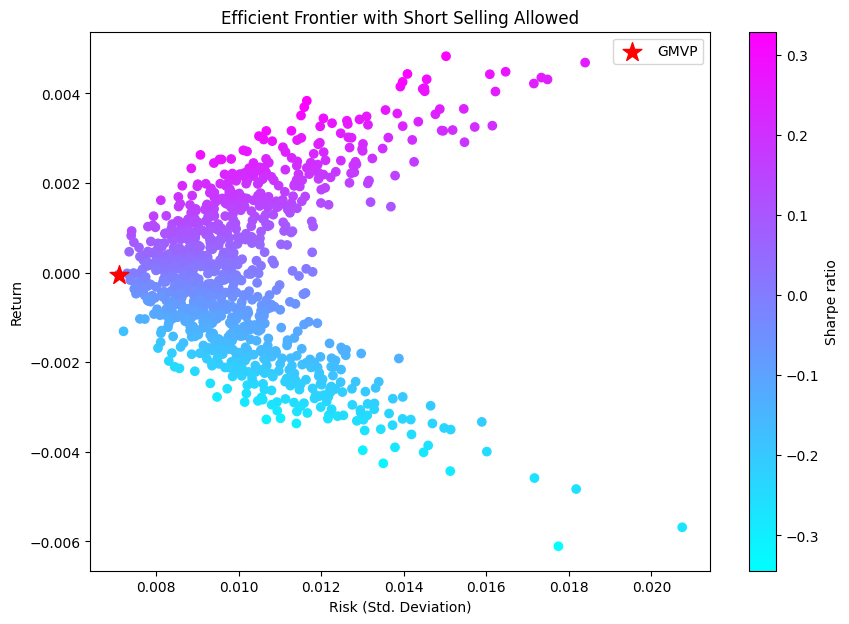

In [39]:
results, weights_record = get_opportunity_set(mean_v, cov_2d, num_portfolios=1000)
# Tangent portfolio
max_sharpe_idx = np.argmax(results[2])
tangent_p_std, tangent_p_ret = results[1, max_sharpe_idx], results[0, max_sharpe_idx]

# Global minimum variance portfolio
min_vol_idx = np.argmin(results[1])
gmvp_std, gmvp_ret = results[1, min_vol_idx], results[0, min_vol_idx]



# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='cool', marker='o')
plt.colorbar(label='Sharpe ratio')
plt.scatter(gmvp_std, gmvp_ret, marker='*', color='r', s=200, label='GMVP')
plt.title('Efficient Frontier with Short Selling Allowed')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()


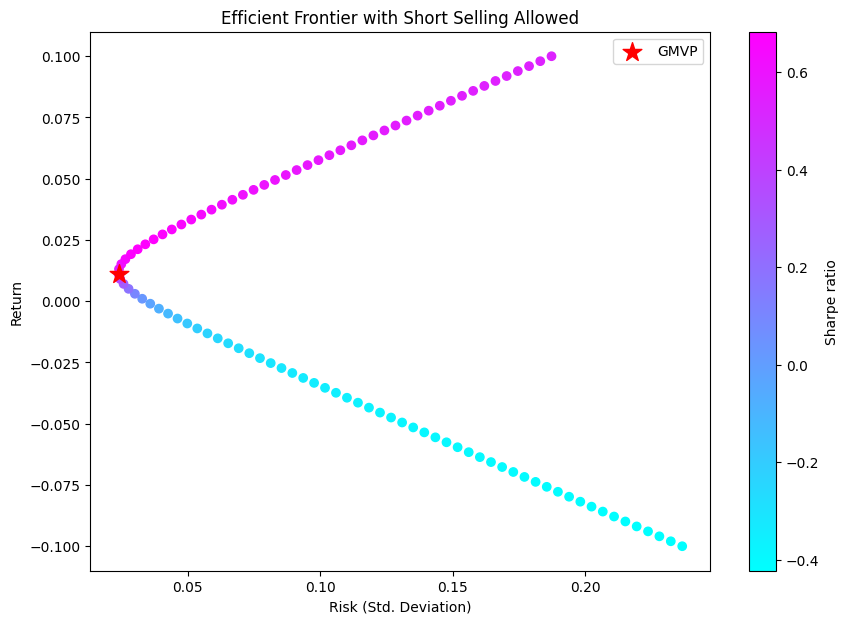

In [40]:
results, weights_record = get_efficient_frontier_parallel(mean_v, cov_2d, num_portfolios=100)

# Global minimum variance portfolio
min_vol_idx = np.argmin(results[1])
gmvp_std, gmvp_ret = results[1, min_vol_idx], results[0, min_vol_idx]

# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='cool', marker='o')
plt.colorbar(label='Sharpe ratio')
plt.scatter(gmvp_std, gmvp_ret, marker='*', color='r', s=200, label='GMVP')
plt.title('Efficient Frontier with Short Selling Allowed')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()


### (b)

In [41]:
sp500_mean = sp500_ret.mean().values[0]

In [42]:
match_sp500_result = optimize_portfolio_given_return(sp500_mean, mean_v, cov_2d)
match_sp500_weights = match_sp500_result.x

match_sp500_weights_df = pd.DataFrame(match_sp500_weights, index=sid_list, columns=['weight'])
match_sp500_weights_df

,weight
ticker,
AAPL,-0.000999
ABT,0.033159
ADBE,-0.011211
ADI,-0.006210
ADP,-0.000275
...,...
VZ,-0.020111
WFC,-0.046306
WM,0.004702


In [ ]:
match_sp500_weights_df.to_csv(OUTPUT_PATH / 'hw1_1.b_match_sp500_weights.csv')

In [44]:
watching = ['MMM', 'BAC', 'AMD', 'AAPL', 'MCD']

match_sp500_weights_df.loc[watching]

,weight
ticker,
MMM,0.136716
BAC,-0.018007
AMD,-0.024008
AAPL,-0.000999
MCD,-0.003414


### (c)

In [63]:
# Tangent portfolio
max_sharpe_idx = np.argmax(results[2])
tangent_p_std, tangent_p_ret = results[1, max_sharpe_idx], results[0, max_sharpe_idx]
tangent_p_weight = weights_record[max_sharpe_idx]

In [77]:
tangent_excess_ret = msf_excess_ret.multiply(tangent_p_weight, axis=1).sum(axis=1)

tangent_excess_mean = tangent_excess_ret.mean()
tangent_excess_std = tangent_excess_ret.std()

In [52]:
# Annualize return, std, sharpe ratio

def monthly_to_annual(data_v):
    monthly_mean = data_v.mean()
    monthly_std = data_v.std()

    annual_mean = monthly_mean * 12
    annual_std = monthly_std * np.sqrt(12)

    return annual_mean, annual_std

In [75]:
sp500_annual_excess_mean, sp500_annual_excess_std = monthly_to_annual(sp500_excess_ret)
sp500_annual_excess_mean, sp500_annual_excess_std

(0.06951223826298158, 0.14553101526384796)

In [76]:
sp500_annual_excess_sharpe = sp500_annual_excess_mean / sp500_annual_excess_std
sp500_annual_excess_sharpe

0.47764552550503264

In [80]:
tangent_p_mean_annual = tangent_excess_mean * 12
tangent_p_std_annual = tangent_excess_std * np.sqrt(12)

tangent_p_mean_annual, tangent_p_std_annual

(0.10803386379714905, 0.08301884173964749)

In [81]:
tangent_annual_sharpe = tangent_p_mean_annual / tangent_p_std_annual
tangent_annual_sharpe

1.3013174061853368

### (d)

In [57]:
tangent_p_weight = weights_record[max_sharpe_idx]

tangent_p_ret = np.dot(tangent_p_weight, msf_ret.to_numpy().T)

In [58]:
tangent_p_cum_ret = np.cumprod(1 + tangent_p_ret) - 1

In [59]:
sp500_cum_ret = np.cumprod(1 + sp500_ret.to_numpy()) - 1

<Axes: xlabel='mdate'>

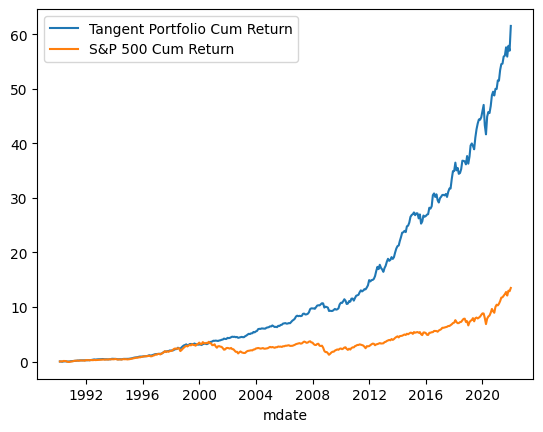

In [60]:
sns.lineplot(y=tangent_p_cum_ret[1:], x=date_list[1:], label='Tangent Portfolio Cum Return')
sns.lineplot(y=sp500_cum_ret, x=date_list[1:], label='S&P 500 Cum Return')


## 2. There is risk-free asset & Short-selling is allowed

Case #1